In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

## Step 1: Load the Dataset

In [47]:
df = pd.read_csv("data_censored.csv")

## Step 2: Data Preparation

In [48]:
columns = ["id", "period", "treatment", "x1", "x2", "x3", "x4", "age", "age_s", "outcome", "censored", "eligible"]
df = df[columns]

## Step 3: Apply Clustering Before IPCW
# Rationale: Clustering helps group similar patients together, allowing us to apply different IPCW models for each group.
# This can improve weighting accuracy and reflect different risk profiles among subgroups.

In [49]:
scaler = StandardScaler()
X_cluster = df[["x2", "x1", "age"]]
X_scaled = scaler.fit_transform(X_cluster)

kmeans = KMeans(n_clusters=3, random_state=42)
df["cluster"] = kmeans.fit_predict(X_scaled)

## Step 4: Fit IPCW for Each Cluster

In [50]:
weights = []
for cluster in df["cluster"].unique():
    cluster_data = df[df["cluster"] == cluster].copy()
    X = cluster_data[["x2", "x1"]]
    y = 1 - cluster_data["censored"]  
    
   
    X_scaled = scaler.fit_transform(X)
    
    
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
    
   
    log_reg = LogisticRegression()
    log_reg.fit(X_train, y_train)
    
   
    cluster_data.loc[:, "ipcw_weight"] = log_reg.predict_proba(X_scaled)[:, 1]
    weights.append(cluster_data)

df = pd.concat(weights)


## Step 6: Expand Trials with Clustering

In [52]:
expanded_df = df.copy()
expanded_df["trial_period"] = expanded_df["period"]
expanded_df["followup_time"] = expanded_df.groupby("id")["period"].cumsum()
expanded_df["assigned_treatment"] = expanded_df["treatment"]

## Step 7: Fit Marginal Structural Model (MSM)

In [53]:
X_msm = expanded_df[["assigned_treatment", "x2", "followup_time", "cluster"]]
y_msm = expanded_df["outcome"]

log_reg_msm = LogisticRegression()
log_reg_msm.fit(X_msm, y_msm)

LogisticRegression()

## Step 8: Survival Analysis - Kaplan-Meier Estimator

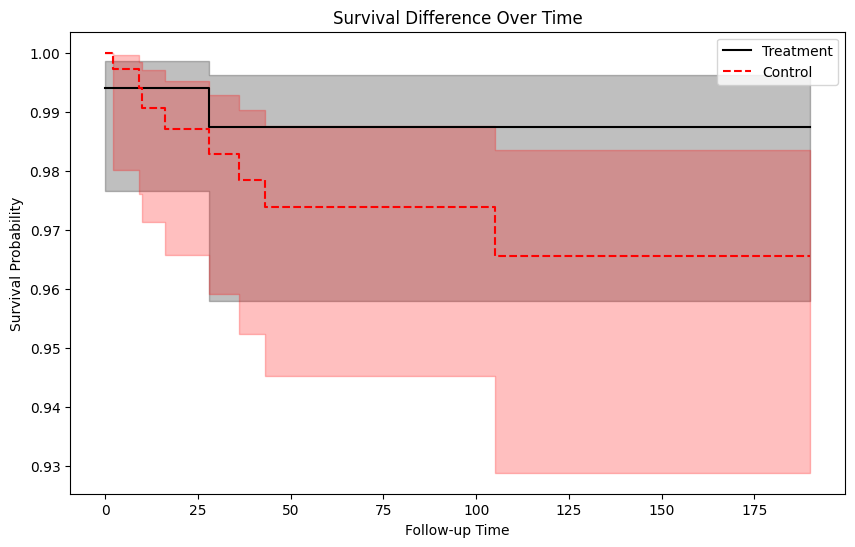

In [55]:
# Try importing lifelines for survival analysis, handle errors if not installed
try:
    from lifelines import KaplanMeierFitter
    lifelines_installed = True
except ImportError:
    print("⚠️ Warning: 'lifelines' package is not installed. Please install it using: pip install lifelines")
    lifelines_installed = False

# ## Step 8: Survival Analysis - Kaplan-Meier Estimator (If available)
if lifelines_installed:
    # Compute survival curves for different treatment groups
    kmf_treatment = KaplanMeierFitter()
    kmf_control = KaplanMeierFitter()

    # Split data based on treatment
    treatment_group = expanded_df[expanded_df["assigned_treatment"] == 1]
    control_group = expanded_df[expanded_df["assigned_treatment"] == 0]

    # Fit Kaplan-Meier models
    kmf_treatment.fit(durations=treatment_group["followup_time"], event_observed=treatment_group["outcome"])
    kmf_control.fit(durations=control_group["followup_time"], event_observed=control_group["outcome"])

    # Plot survival difference
    plt.figure(figsize=(10, 6))
    kmf_treatment.plot_survival_function(label="Treatment", color="black")
    kmf_control.plot_survival_function(label="Control", linestyle="dashed", color="red")
    plt.xlabel("Follow-up Time")
    plt.ylabel("Survival Probability")
    plt.title("Survival Difference Over Time")
    plt.legend()
    plt.show()
else:
    print("Skipping survival analysis as 'lifelines' is not installed.")


## Insights
# Clustering before IPCW allows different patient groups to have separate weighting models,
# improving the accuracy of survival estimates and bias reduction. Clusters with distinct IPCW weight
# distributions suggest differences in treatment adherence or censoring mechanisms among subgroups.
# The survival plot visualizes how treatment groups differ in survival probability over time.